In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs

In [162]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[i] for i in y if i != padding_index])

In [4]:
dataset = IAMParagraphs()
dataset.prepare_data()
dataset.setup()
print(dataset)

2021-04-08 21:48:18.431 | INFO     | text_recognizer.data.iam_paragraphs:setup:106 - Loading IAM paragraph regions and lines for None...


IAM Paragraphs Dataset
Num classes: 84
Input dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 1046, 262, 231
Train Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0371), tensor(0.1049), tensor(1.))
Train Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))
Test Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0284), tensor(0.0846), tensor(0.9373))
Test Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))



In [163]:
x, y = dataset.data_train[1]

In [164]:
y

tensor([ 1, 33, 47, 44, 66, 51, 40, 59, 59, 44, 57, 66, 43, 54, 66, 53, 54, 59,
        66, 57, 44, 46, 40, 57, 43, 66, 59, 47, 44, 52, 58, 44, 51, 61, 44, 58,
        66, 40, 58, 66, 44, 63, 55, 44, 57, 59, 83, 40, 43, 61, 48, 58, 44, 57,
        58, 76, 66, 41, 60, 59, 66, 40, 57, 44, 66, 55, 57, 44, 55, 40, 57, 44,
        43, 66, 59, 54, 66, 58, 44, 44, 50, 66, 54, 60, 59, 66, 59, 47, 44, 83,
        40, 55, 55, 57, 54, 55, 57, 48, 40, 59, 44, 66, 58, 54, 60, 57, 42, 44,
        58, 66, 54, 45, 66, 48, 53, 45, 54, 57, 52, 40, 59, 48, 54, 53, 66, 54,
        57, 66, 40, 43, 61, 48, 42, 44, 78, 83, 33, 54, 62, 40, 57, 43, 58, 66,
        59, 47, 44, 66, 44, 53, 43, 66, 54, 45, 66,  5, 13,  9, 10, 76, 66, 26,
        57, 78, 66, 17, 40, 53, 48, 44, 51, 66, 20, 57, 40, 53, 59, 76, 83, 40,
        53, 66, 18, 52, 55, 51, 54, 64, 44, 44, 66, 31, 44, 51, 40, 59, 48, 54,
        53, 58, 66, 28, 45, 45, 48, 42, 44, 57, 66, 54, 45, 83, 31, 54, 51, 51,
        58, 77, 31, 54, 64, 42, 44, 66, 

In [165]:
from text_recognizer.data.iam_preprocessor import Preprocessor
from pathlib import Path

In [166]:
processor = Preprocessor(
                            data_dir=Path("../data/downloaded/iam/iamdb"),
                            num_features=1000,
                            lexicon_path=Path("../data/processed/iam_lines/iamdb_1kwp_lex_1000.txt"),
                            tokens_path=Path("../data/processed/iam_lines/iamdb_1kwp_tokens_1000.txt"),
                            use_words=True,
                            prepend_wordsep=False,
                            special_tokens=["<s>", "<e>", "<p>", "\n"]
)

In [167]:
t = convert_y_label_to_string(y, dataset.mapping)

In [168]:
t

"<s>The latter do not regard themselves as expert\nadvisers, but are prepared to seek out the\nappropriate sources of information or advice.\nTowards the end of 1956, Mr. Daniel Grant,\nan Employee Relations Officer of\nRolls-Royce Ltd. and a member of the\nWorkers' Educational Association, submitted\nto the Lord Provost of Glasgow, Dr. Andrew\nHood, a copy of his report on an enquiry\nhe had made into the problems that beset\nolder workers and the effects of retirement\nHugentobler Roger<e>"

In [170]:
ii = processor.to_index(t.replace(" ", "▁").lower())

In [171]:
ii.shape

torch.Size([247])

In [172]:
ii.shape

torch.Size([247])

In [176]:
processor.to_text(ii)

"<s>▁the▁latter▁do▁not▁regard▁themselves▁as▁expert\n▁advisers,▁but▁are▁prepared▁to▁seek▁out▁the\n▁appropriate▁sources▁of▁information▁or▁advice.\n▁towards▁the▁end▁of▁1956,▁mr.▁daniel▁grant,\n▁an▁employee▁relations▁officer▁of\n▁rolls-royce▁ltd.▁and▁a▁member▁of▁the\n▁workers'▁educational▁association,▁submitted\n▁to▁the▁lord▁provost▁of▁glasgow,▁dr.▁andrew\n▁hood,▁a▁copy▁of▁his▁report▁on▁an▁enquiry\n▁he▁had▁made▁into▁the▁problems▁that▁beset\n▁older▁workers▁and▁the▁effects▁of▁retirement\n▁hugentobler▁roger<e>"

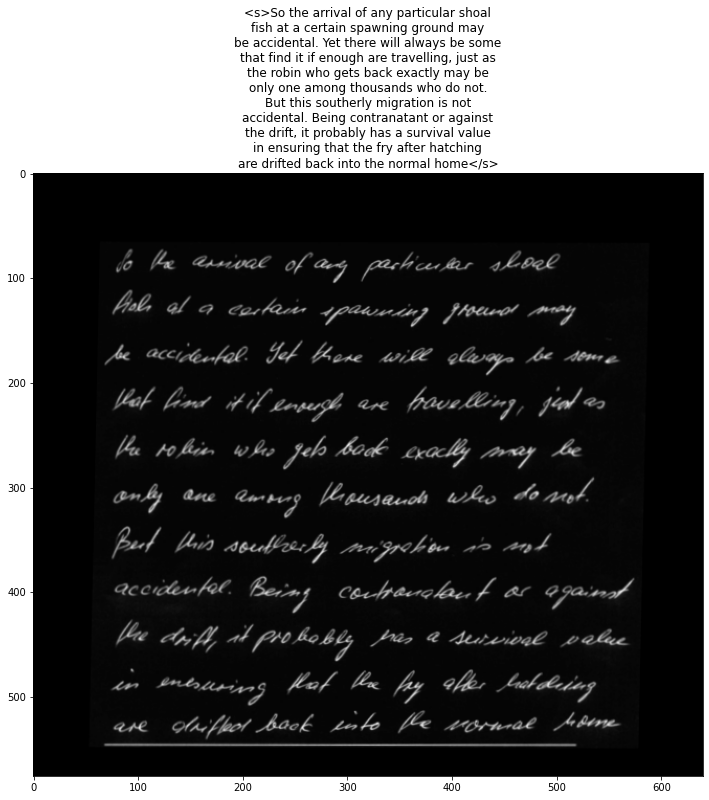

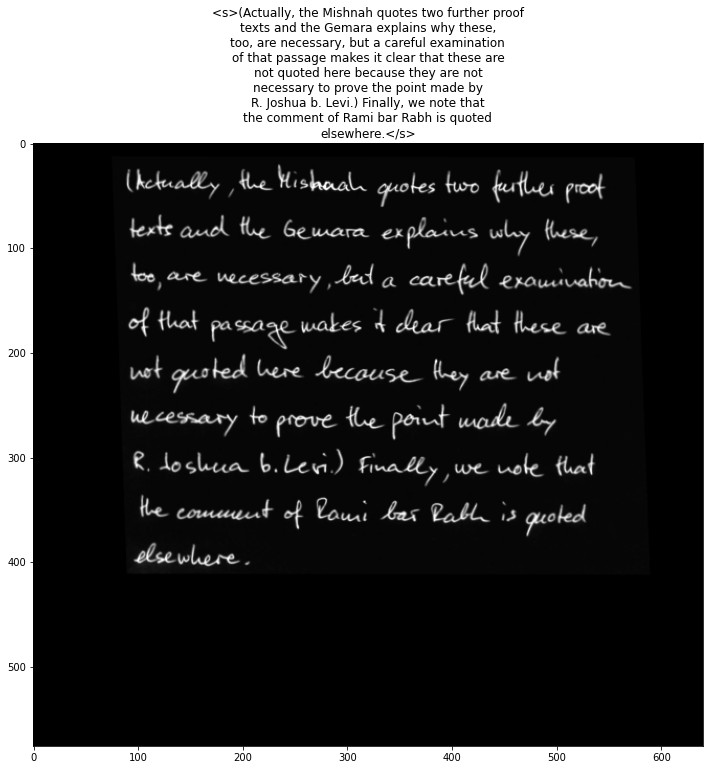

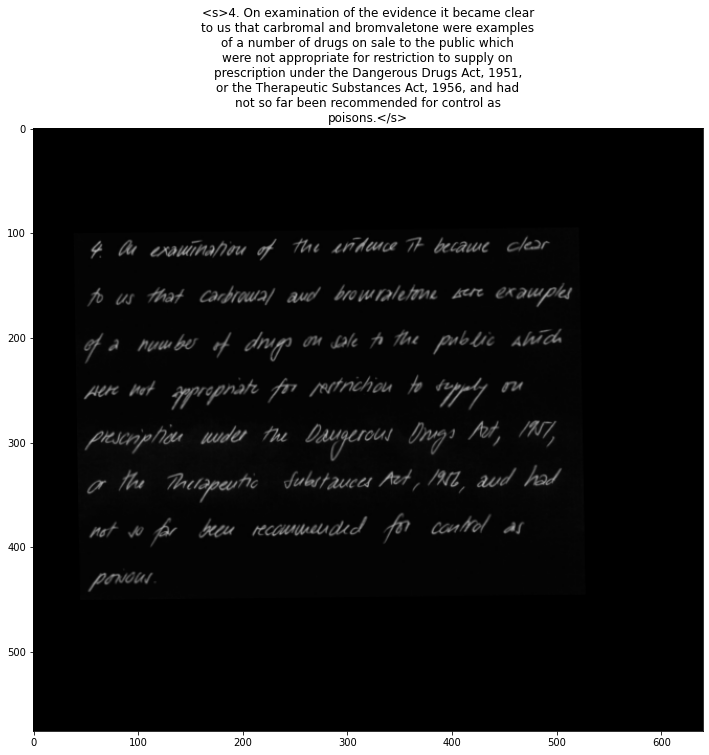

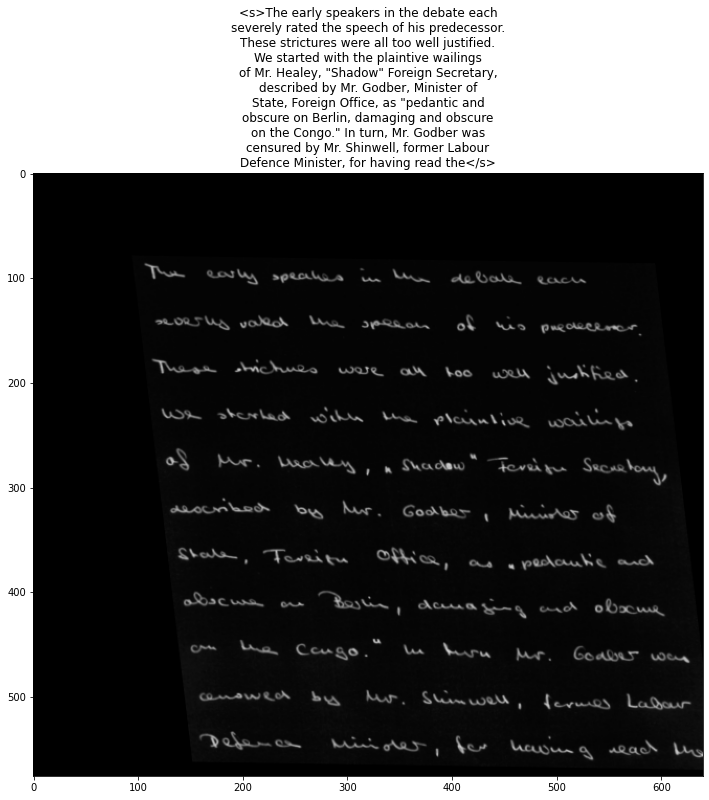

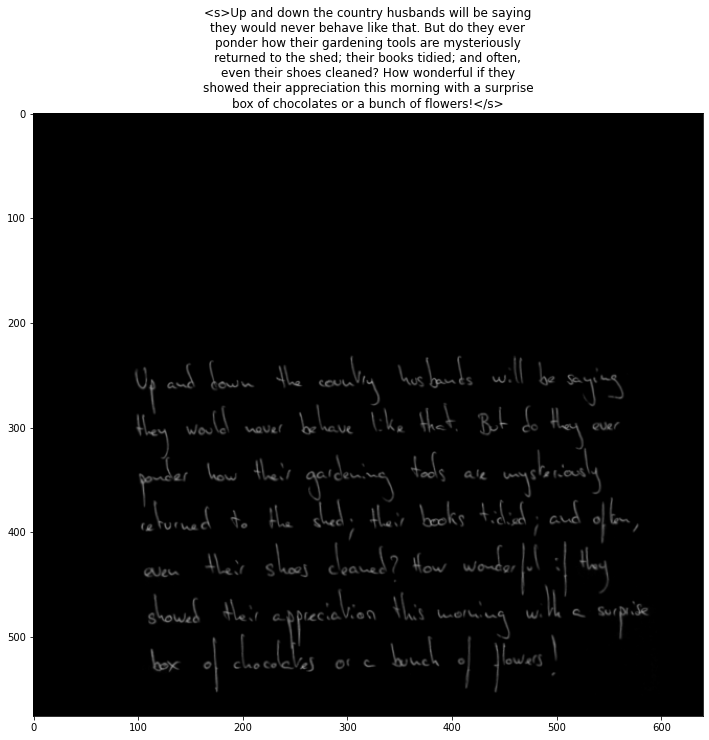

In [4]:
# Training

for _ in range(5):
    i = random.randint(0, len(dataset.data_train))
    x, y = dataset.data_train[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

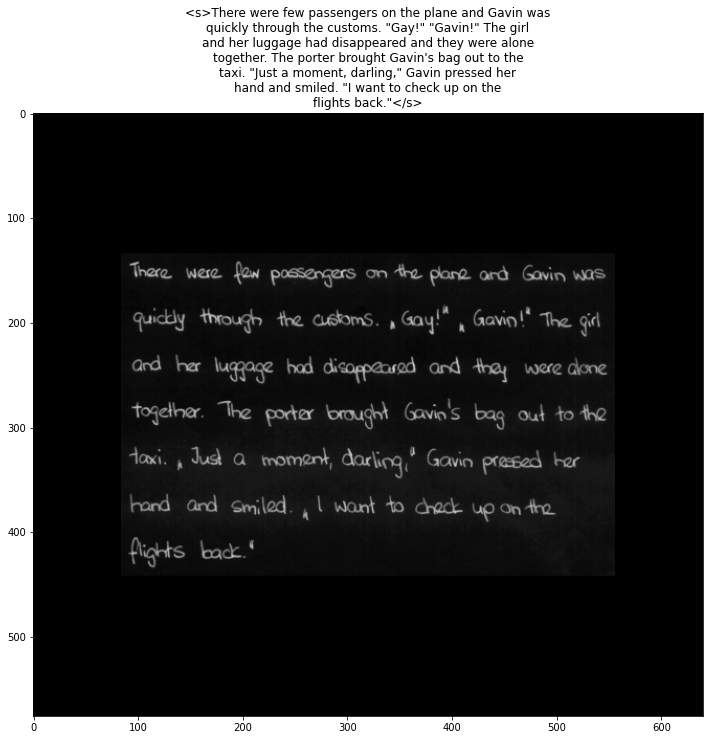

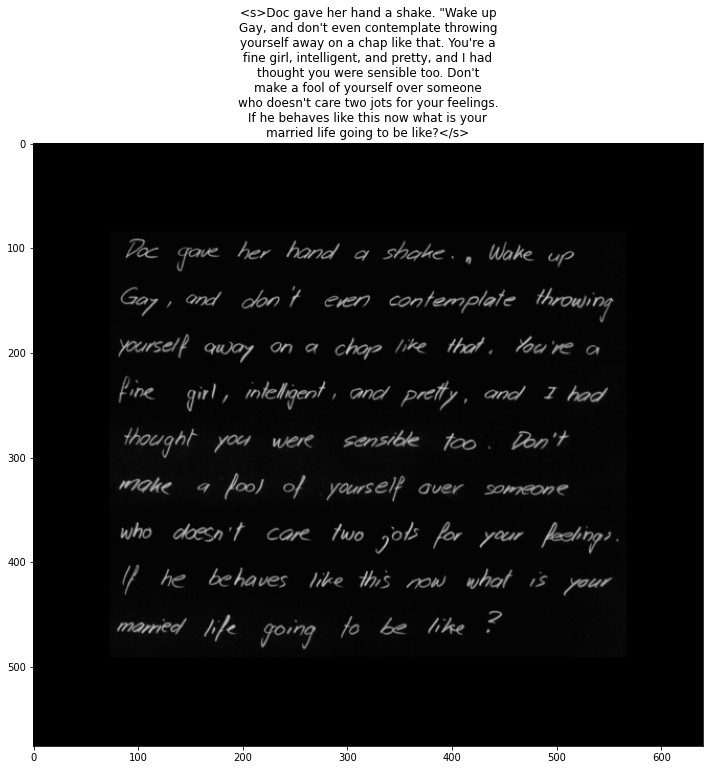

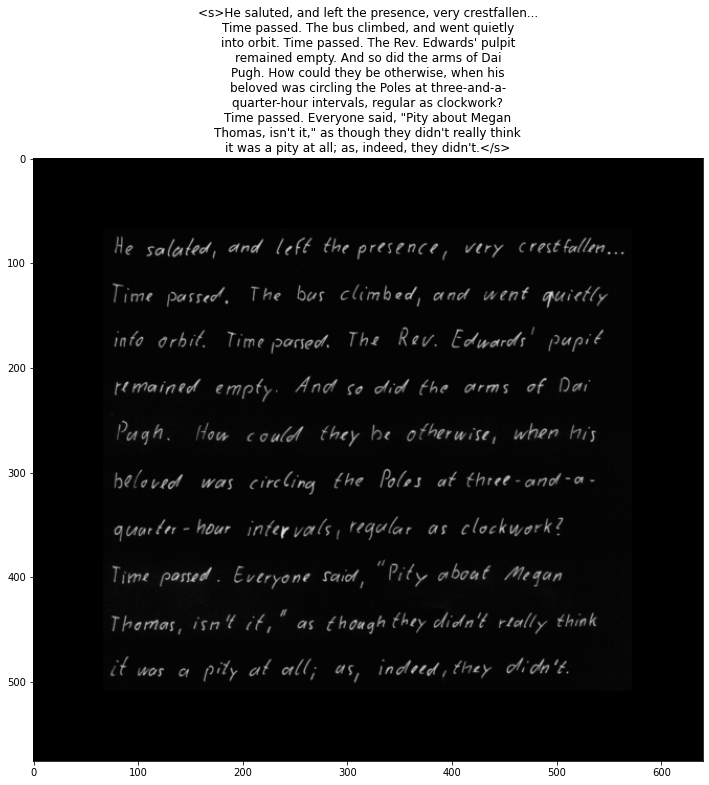

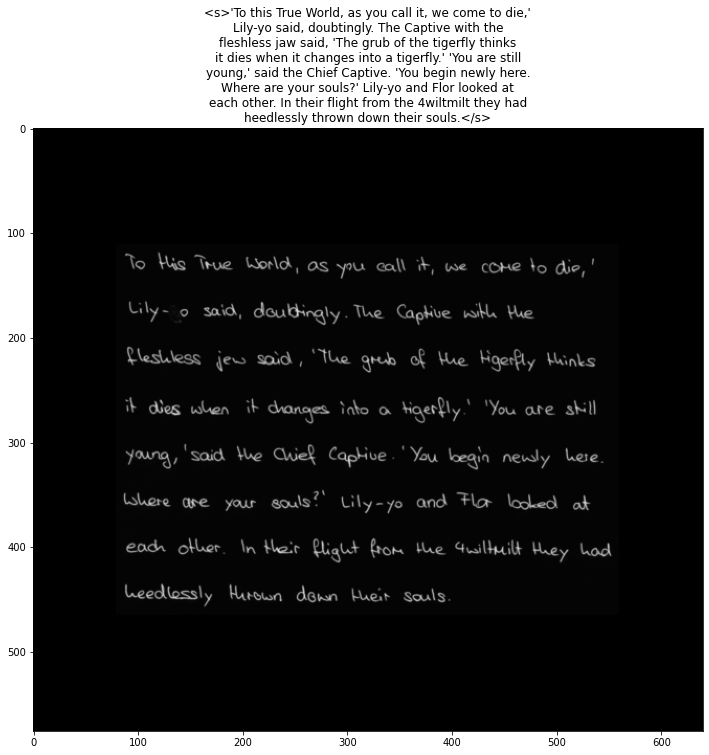

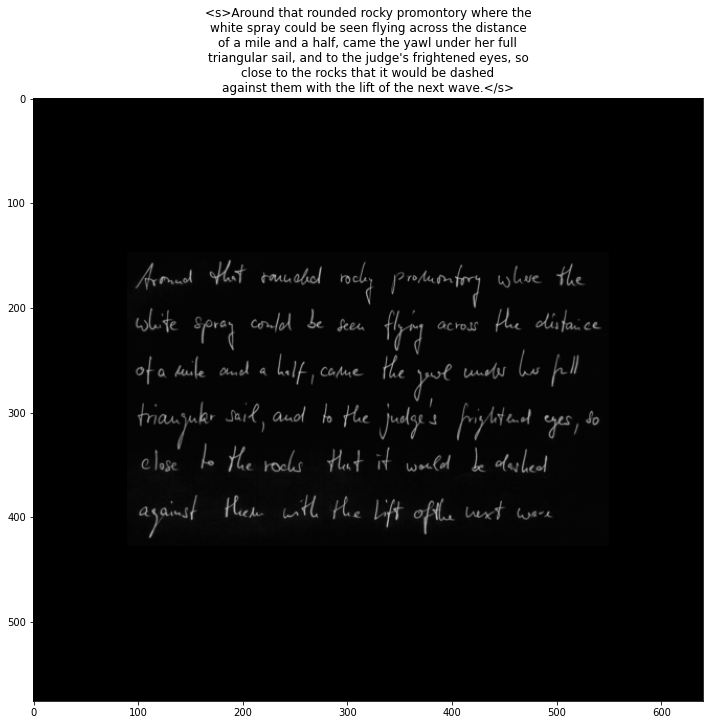

In [5]:

# Testing

for _ in range(5):
    i = random.randint(0, len(dataset.data_test))
    x, y = dataset.data_test[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

In [8]:
dataset = IAMSyntheticParagraphs()
dataset.prepare_data()
dataset.setup()
print(dataset)

2021-04-03 23:42:20.849 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:59 - IAM Synthetic dataset steup for stage None


IAM Synthetic Paragraphs Dataset
Num classes: 84
Input dims : (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 18896, 0, 0
Train Batch x stats: (torch.Size([128, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0108), tensor(0.0579), tensor(1.))
Train Batch y stats: (torch.Size([128, 682]), torch.int64, tensor(1), tensor(83))



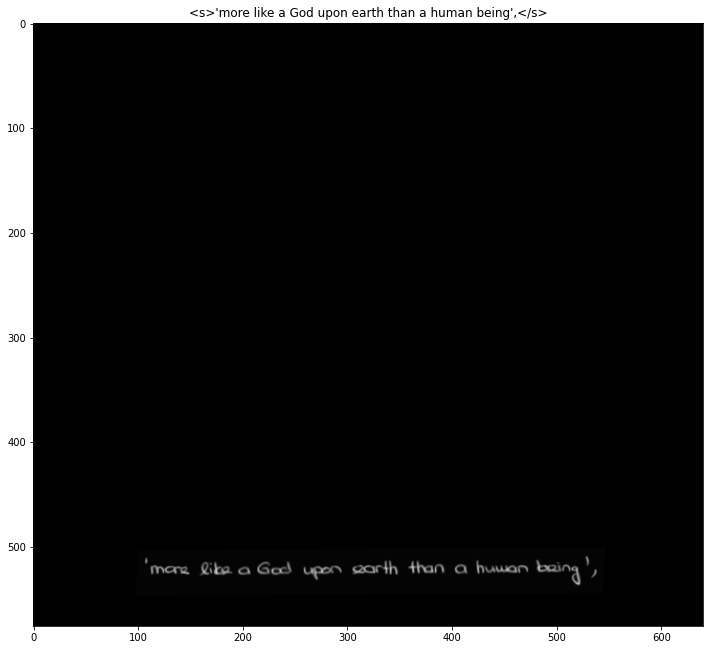

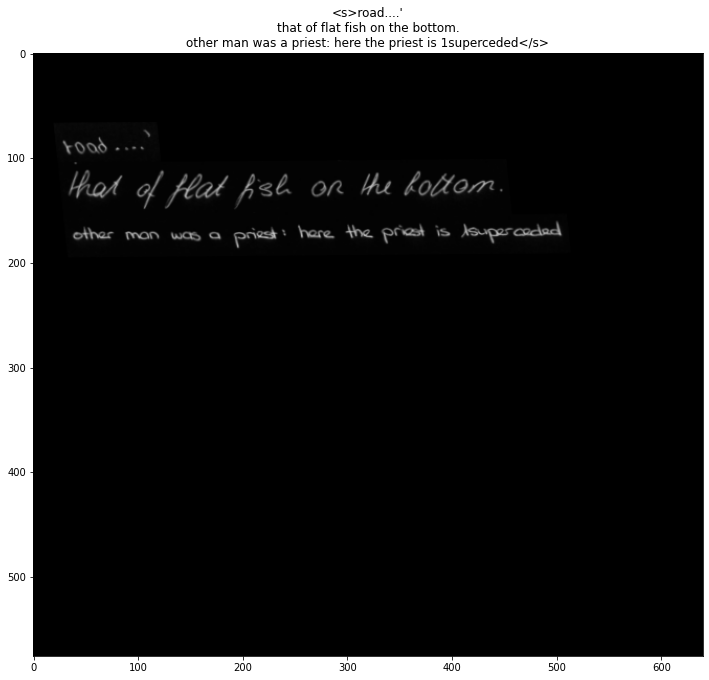

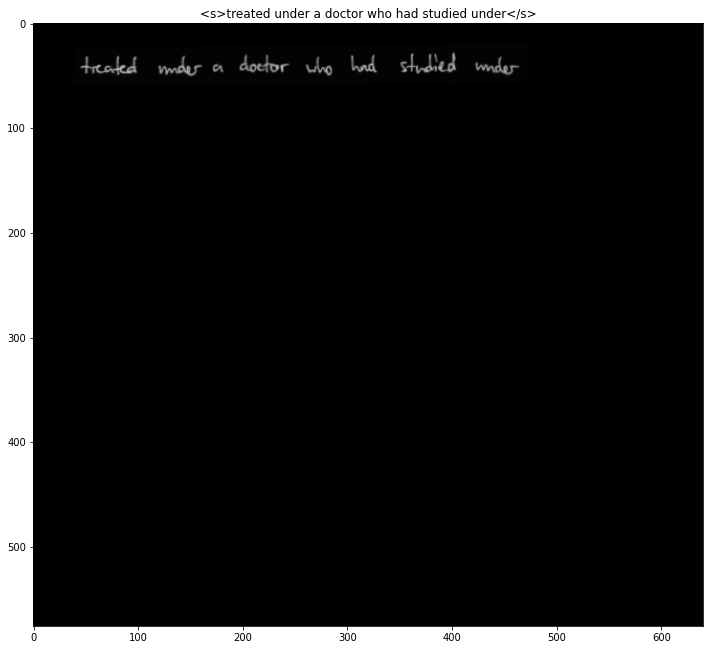

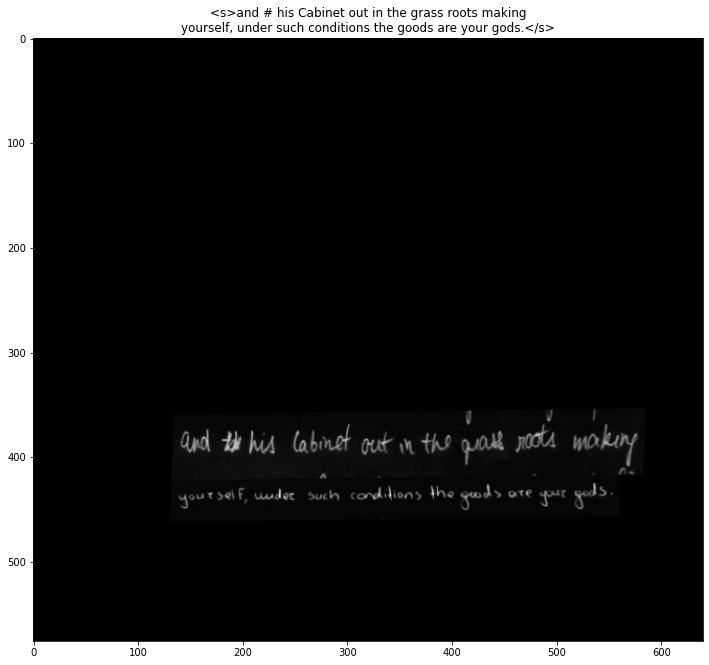

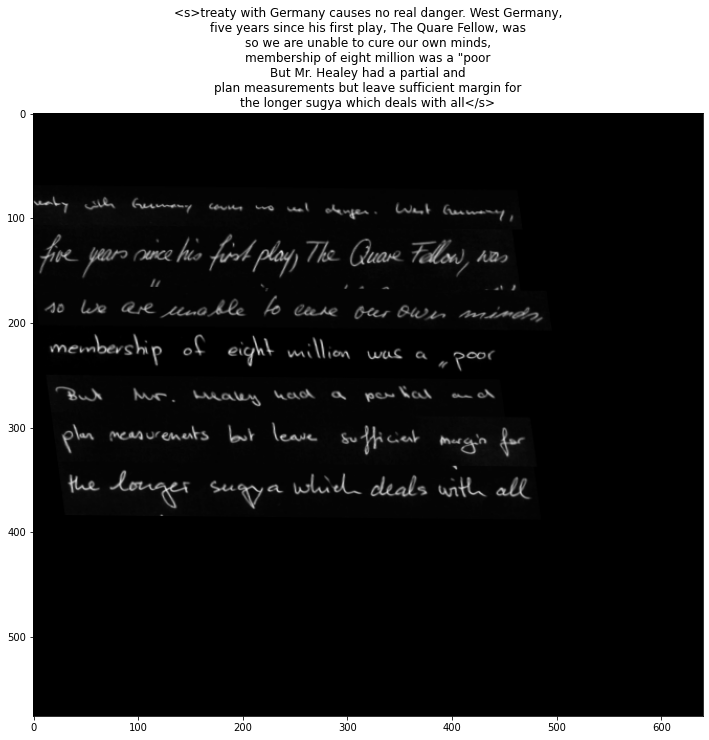

In [9]:
# Training

for _ in range(5):
    i = random.randint(0, len(dataset.data_train))
    x, y = dataset.data_train[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))